# Regression

## Objectives

*   Fit and evaluate a regression model to predict profit and loss given the position recommended (ie. buy and sell)


## Inputs

* C:\Users\sunny\Desktop\Development\python\NeuralPricing\Input\USDJPY_prices.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict tenure
* labels map
* Feature Importance Plot



---

# 1. Load Data

In [1]:
# import sys
# sys.path.append('..')  # Add the parent directory to the path

import pandas as pd
import numpy as np
import os
# from data_processing import main



In [2]:
# Go one level up from the current working directory
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))
input_folder = rf"{parent_directory}\inputs\USDJPY_prices.csv"
output_folder = rf"{parent_directory}\outputs"

#this is to ensure the data_processing.py script gets imported
data_path = rf"{parent_directory}\untracked_files\data_processing.py"
data_path = data_path.replace("\\", "/")
print(data_path)
%run "{data_path}"

# %run "C:\Users\sunny\Desktop\Development\python\NeuralPricing\jupyter_notebooks\data_processing.py"

#call on data_processing.py script main function to calculate all relevant data used in machine training.
#Note to drop date before using.
df = main(input_folder)
# in case the original dataframe is needed.
# ori_df = df.copy()
df.drop(columns=['date', 'time', 'high', 'open', 'close', 'low'], inplace= True)
print(df.head(10))

c:/Users/sunny/Desktop/Development/python/NeuralPricing/untracked_files/data_processing.py
c:\Users\sunny\Desktop\Development\python\NeuralPricing\inputs\USDJPY_prices.csv
                   date     open     high      low    close     ma20_1  \
399 2023-01-30 16:00:00  130.317  130.480  130.290  130.349  129.96440   
400 2023-01-30 17:00:00  130.346  130.417  130.306  130.411  129.99450   
401 2023-01-30 18:00:00  130.415  130.490  130.343  130.423  130.02540   
402 2023-01-30 19:00:00  130.422  130.610  130.397  130.557  130.06160   
403 2023-01-30 20:00:00  130.555  130.558  130.420  130.463  130.08050   
404 2023-01-30 21:00:00  130.463  130.469  130.400  130.440  130.09120   
405 2023-01-30 22:00:00  130.417  130.446  130.343  130.378  130.10655   
406 2023-01-30 23:00:00  130.367  130.533  130.350  130.481  130.13495   
407 2023-01-31 00:00:00  130.487  130.506  130.268  130.299  130.17590   
408 2023-01-31 01:00:00  130.301  130.310  130.100  130.130  130.20055   
409 2023-01-31

In [3]:
#check which attributes are string content
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)

['year', 'month', 'day', 'weekday_name', 'bb_status_1']


The following scale the PL by a 100 times!

In [99]:
# Convert to pips for the the profit and loss by applying 100 
df['pl_close_4_hr'] = round(df['pl_close_4_hr'] * 100, 0).fillna(0).astype(int)
print(df['pl_close_4_hr'])

399    -2800
400    -2800
401    -1600
402    -2500
403    -1100
        ... 
4255    6600
4256    7500
4257    7000
4258    5600
4259    3400
Name: pl_close_4_hr, Length: 3804, dtype: int32


In [4]:
#output the data to a csv file for further external analysis
df.to_csv(rf"{output_folder}\usdjpy_historical_prices.csv",index=False)

# MP Pipeline: Regressor

## Create ML pipeline

In [171]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['bb_status_1', 'month', 'time', 'weekday_name'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


Custom Class for hyperparameter optimisation

In [172]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['pl_close_4_hr'], axis=1),
    df['pl_close_4_hr'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (3043, 34) (3043,) 
* Test set: (761, 34) (761,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [174]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [105]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se

Check results

In [106]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.597972,0.661234,0.690079,0.033521
2,RandomForestRegressor,0.587287,0.64755,0.687789,0.035093
0,LinearRegression,0.605354,0.624969,0.662512,0.019739
3,ExtraTreesRegressor,0.546555,0.620435,0.661151,0.039454
6,XGBRegressor,0.529902,0.564192,0.606185,0.026018
4,AdaBoostRegressor,0.268133,0.438777,0.530104,0.091087
1,DecisionTreeRegressor,0.244033,0.389075,0.473047,0.076998


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [108]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may consider more hyperparameters and spend more time in this step

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV

In [109]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se

Check results

In [110]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
7,GradientBoostingRegressor,0.616646,0.66258,0.690958,0.026578,0.01,3,300
0,GradientBoostingRegressor,0.597972,0.661234,0.690079,0.033521,0.1,3,100
1,GradientBoostingRegressor,0.553971,0.638267,0.671914,0.043151,0.1,3,300
9,GradientBoostingRegressor,0.53445,0.59438,0.648368,0.037125,0.01,10,300
6,GradientBoostingRegressor,0.537464,0.562317,0.594165,0.020622,0.01,3,100
2,GradientBoostingRegressor,0.493241,0.5601,0.631514,0.046062,0.1,10,100
8,GradientBoostingRegressor,0.512276,0.550042,0.578745,0.02229,0.01,10,100
3,GradientBoostingRegressor,0.430403,0.519773,0.622562,0.0657,0.1,10,300
10,GradientBoostingRegressor,0.420411,0.474301,0.510768,0.029755,0.01,None,100
11,GradientBoostingRegressor,0.3288,0.419998,0.503251,0.055991,0.01,None,300


Check the best model

In [111]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [112]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 300}

Define the best regressor, based on search

In [113]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['bb_status_1', 'month', 'time',
                                           'weekday_name'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['open', 'high', 'low',
                                                     'close', 'ma20_1',
                                                     'ma50_1', 'ma100_1',
                                                     'month', 'time', 'hr',
                                                     '4hr...
                                                     'close_ma100_1_diff_1',
                                                     'ma20_1_ma50_1_diff_1',
         

## Assess feature importance

* These are the 3 most important features in descending order. The model was trained on them: 
['trade_close_4_hr', 'close_ma50_1_diff_1', 'bb_status_1']


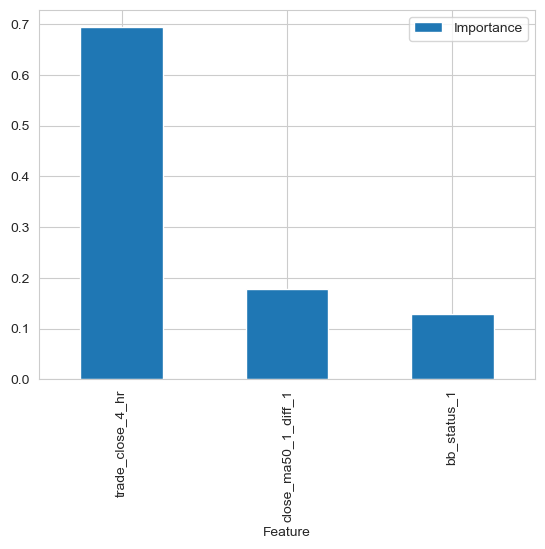

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [116]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.688
Mean Absolute Error: 1414.399
Mean Squared Error: 3936320.597
Root Mean Squared Error: 1984.016


* Test Set
R2 Score: 0.563
Mean Absolute Error: 1557.288
Mean Squared Error: 5417688.176
Root Mean Squared Error: 2327.593




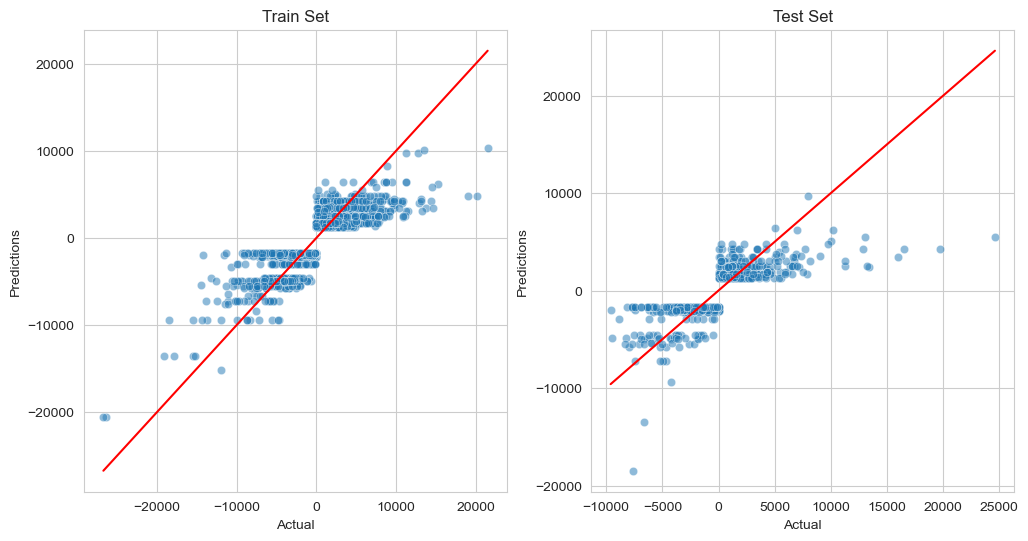

In [117]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Regressor with PCA

Let's explore potential values for PCA n_components.

In [ ]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['pl_close_4_hr'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

Apply PCA separately to the scaled data

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 10


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


In [ ]:
n_components = 7
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [ ]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                      variables=['bb_status', 'month', 'time', 'weekday_name', 'market_state_lag1', 'market_bb'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


## Grid Search CV – Sklearn

In [ ]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

### Use standard hyperparameters to find the most suitable model.

In [ ]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optimisation search 

In [ ]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [ ]:
models_search = {
    "ExtraTreesRegressor":ExtraTreesRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300],
        'model__max_depth': [None, 3, 10],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__bootstrap': [True, False],
        'model__criterion': ['mse', 'mae']
    }

}

Extensive GridSearch CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters for best model

In [ ]:
grid_search_pipelines[best_model].best_params_

Define the best regressor

In [ ]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

## Evaluate Regressor on Train and Tests Sets

In [ ]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

# 3. Convert Regression to Classification

### Convert numerical target to bins, and check if it is balanced

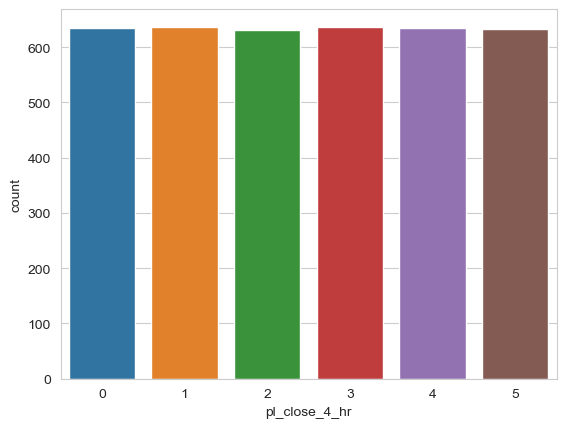

In [175]:
from feature_engine.discretisation import EqualFrequencyDiscretiser

# Auto create the bins
disc = EqualFrequencyDiscretiser(q=6, variables=['pl_close_4_hr'])  # we will try q as 2, and 3
df_clf = disc.fit_transform(df)

#print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")

sns.countplot(data=df_clf, x='pl_close_4_hr')
plt.show()


In [176]:

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)
print(type(df['pl_close_4_hr']))

['year', 'month', 'day', 'weekday_name', 'bb_status_1']
<class 'pandas.core.series.Series'>


## 3.1 Rewrite ML Pipeline for Modelling

In [182]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['year', 'month', 'day', 'weekday_name', 'bb_status_1'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


## 3.2 Load algorithms for classification

In [183]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

## 3.3 Split Train Test Sets

In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['pl_close_4_hr', 'trade_close_4_hr', 'trade_close_1_hr', 'pl_close_1_hr'], axis=1),
    df_clf['pl_close_4_hr'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (3043, 31) (3043,) 
* Test set: (761, 31) (761,)


## 3.4 Grid Seach CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [185]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [186]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se


Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se

Check results

In [187]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestClassifier,0.656863,0.686846,0.715686,0.02288
4,ExtraTreesClassifier,0.578431,0.635903,0.68932,0.04162
5,AdaBoostClassifier,0.578431,0.612507,0.637255,0.021376
3,GradientBoostingClassifier,0.529412,0.586979,0.640777,0.037368
1,DecisionTreeClassifier,0.470588,0.563583,0.676471,0.068748
0,XGBClassifier,0.421569,0.477422,0.529412,0.039869


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define models and parameters

In [188]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
}

# documentation to help on hyperparameter list:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [50, 100, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    }
}


Extensive GridSearch CV

In [189]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)



Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se

Check results

In [190]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
94,RandomForestClassifier,0.647059,0.69663,0.735294,0.030119,30,2,5,100
13,RandomForestClassifier,0.647059,0.69663,0.735294,0.030119,None,2,5,100
22,RandomForestClassifier,0.656863,0.694689,0.72549,0.02302,None,4,5,100
19,RandomForestClassifier,0.656863,0.694689,0.72549,0.02302,None,4,2,100
100,RandomForestClassifier,0.656863,0.694689,0.72549,0.02302,30,4,2,100
...,...,...,...,...,...,...,...,...,...
41,RandomForestClassifier,0.607843,0.655473,0.708738,0.039678,10,2,5,300
37,RandomForestClassifier,0.558824,0.651571,0.699029,0.049612,10,2,2,100
30,RandomForestClassifier,0.607843,0.649629,0.68932,0.027464,10,1,5,50
33,RandomForestClassifier,0.617647,0.64763,0.708738,0.033265,10,1,10,50



Check the best model

In [191]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

Parameters for best model
* We are saving this content for later

In [192]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 5,
 'model__n_estimators': 100}

Define the best clf pipeline

In [193]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['year', 'month', 'day',
                                           'weekday_name', 'bb_status_1'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['ma20_1', 'ma50_1',
                                                     'ma100_1', 'year', 'month',
                                                     'day', 'hr', '4hr_tf',
                                                     'weekday', '...
                                                     'up_bb20_low_bb20_diff_4',
                                                     'close_ma20_4_diff_4',
                                                     'close_

## 3.5 Assess feature importance

We can assess feature importance for this model with `.feature_importances_`

* These are the 9 most important features in descending order. The model was trained on them: 
['close_ma50_1_diff_1', 'trend_strength_1', 'up_bb20_low_bb20_diff_1', 'hr', 'lagged_close_1', 'up_bb20_low_bb20_diff_4', 'close_ma100_4_diff_4', 'ma50_4_ma100_4_diff_4', 'ma20_4_ma50_4_diff_4']


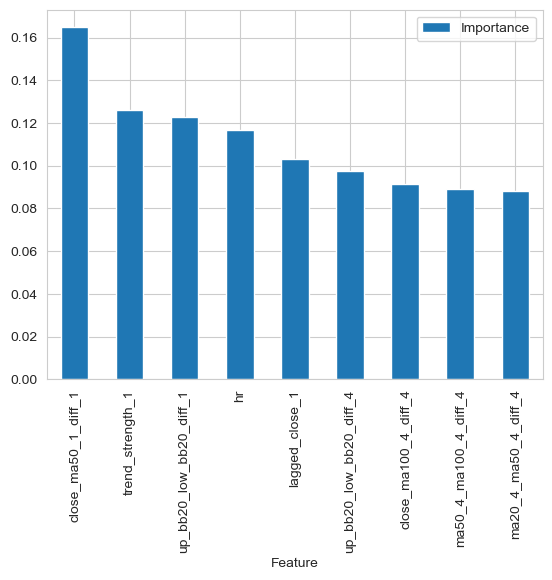

In [194]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## 3.6 Evaluate Classifier on Train and Test Sets

Custom Function

In [195]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


List that relates the classes and tenure interval

In [196]:
disc.binner_dict_['pl_close_4_hr']

[-inf,
 -0.2861666666666642,
 -0.11299999999999955,
 -0.013999999999995794,
 0.09199999999998454,
 0.23799999999999955,
 inf]

We can create manually

In [197]:
# label_map = ['<-29', '-29 to -11', '-11 to -1.0','-1 to 9', '9 to 25', '25+']
label_map = ['-25<', '-20', '-5','5', '20', '>25']
label_map

['-25<', '-20', '-5', '5', '20', '>25']

In [198]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                Actual -25< Actual -20 Actual -5 Actual 5 Actual 20 Actual >25
Prediction -25<         502          3         3        0         1          1
Prediction -20            4        488         6        1         0          0
Prediction -5             1          3       473        2         1          0
Prediction 5              0          1         2      507         3          2
Prediction 20             1          1         2        6       507          3
Prediction >25            3          1         2        4         7        502


---  Classification Report  ---
              precision    recall  f1-score   support

        -25<       0.98      0.98      0.98       511
         -20       0.98      0.98      0.98       497
          -5       0.99      0.97      0.98       488
           5       0.98      0.97      0.98       520
          20       0.97      0.98      0.98       519
         >25       0.97      0.99      

# Which pipeline to choose?

We fitted 3 pipelines:
* Regression
* Regression with PCA
* Classifier

The regressor pipelines didn't reach the expected performance threshold (0.7 R2 score) for the train and test set.

The classifier was tuned on Recall for class 0 (tenure <4 months), since we are interested to detect prospects that may churn soon. 
* It has reasonable performance for class 0 (<4 months) and class 2 (+20 months)
* Class 1 (4 to 20 months) has weak performance.

In [199]:
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['year', 'month', 'day',
                                           'weekday_name', 'bb_status_1'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['ma20_1', 'ma50_1',
                                                     'ma100_1', 'year', 'month',
                                                     'day', 'hr', '4hr_tf',
                                                     'weekday', '...
                                                     'up_bb20_low_bb20_diff_4',
                                                     'close_ma20_4_diff_4',
                                                     'close_

# 4. Refit pipeline with best features

## Rewrite Pipeline

In [200]:
#update variable that are categoric that will be in your training and testing sets.
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
        #                                              variables=[])),

        ("feat_scaling", StandardScaler()),

        # feature selection is not needed

        ("model", model),

    ])

    return pipeline_base


## 4.1 Split Train Test Set, only with best features

In [201]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['pl_close_4_hr', 'trade_close_4_hr', 'trade_close_1_hr', 'pl_close_1_hr'], axis=1),
    df_clf['pl_close_4_hr'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (3043, 31) (3043,) 
* Test set: (761, 31) (761,)


Subset Best Features

In [202]:
best_features

['close_ma50_1_diff_1',
 'trend_strength_1',
 'up_bb20_low_bb20_diff_1',
 'hr',
 'lagged_close_1',
 'up_bb20_low_bb20_diff_4',
 'close_ma100_4_diff_4',
 'ma50_4_ma100_4_diff_4',
 'ma20_4_ma50_4_diff_4']

In [54]:
#supersede the selection of best features from section 3 with user specified.

best_features = ['close_ma50_diff',
 'up_bb20_low_bb20_diff',
 'close_ma100_diff',
 'lower_bb20_2',
 'trend_strength',
 'bb_status']

In [203]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)



print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (3043, 9) (3043,) 
* Test set: (761, 9) (761,)


,close_ma50_1_diff_1,trend_strength_1,up_bb20_low_bb20_diff_1,hr,lagged_close_1,up_bb20_low_bb20_diff_4,close_ma100_4_diff_4,ma50_4_ma100_4_diff_4,ma20_4_ma50_4_diff_4
3109,-0.24528,2,0.371345,10,144.355,0.692593,1.82156,1.51558,0.42973
1969,1.78130,-4,1.052512,4,136.869,5.007437,3.02263,0.53169,0.18979
4226,-0.17094,0,0.632392,23,147.275,1.677841,1.05685,0.38213,0.71472


## 4.2 Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [204]:
models_search

{'RandomForestClassifier': RandomForestClassifier(random_state=0)}

And the best parameters from the previous GridCV search

In [205]:
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 5,
 'model__n_estimators': 100}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [206]:
#update with above parameters
params_search = {'RandomForestClassifier': {'model__max_depth': [10],
 'model__min_samples_leaf': [4],
 'model__min_samples_split': [2],
 'model__n_estimators': [300]}
}
params_search

{'RandomForestClassifier': {'model__max_depth': [10],
  'model__min_samples_leaf': [4],
  'model__min_samples_split': [2],
  'model__n_estimators': [300]}}

In [207]:
y_train

3109    5
1969    0
4226    2
3165    5
955     4
       ..
1248    5
3710    0
2073    1
3041    4
3168    2
Name: pl_close_4_hr, Length: 3043, dtype: int64

GridSearch CV

In [208]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Check results

In [209]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,RandomForestClassifier,0.120168,0.176395,0.266297,0.050922,10,4,2,300


Check the best model

In [210]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

Define the best clf pipeline

In [211]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        n_estimators=300, random_state=0))])

## 4.3 Assess feature importance

In [214]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

## 4.4 Evaluate Classifier on Train and Test Sets

In [215]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                Actual -25< Actual -20 Actual -5 Actual 5 Actual 20 Actual >25
Prediction -25<         441         43        30       27        18          7
Prediction -20           26        370        45       35        20          8
Prediction -5             9         21       312       24        22          7
Prediction 5              5         15        31      348        31         13
Prediction 20            21         24        38       45       371         39
Prediction >25            9         24        32       41        57        434


---  Classification Report  ---
              precision    recall  f1-score   support

        -25<       0.78      0.86      0.82       511
         -20       0.73      0.74      0.74       497
          -5       0.79      0.64      0.71       488
           5       0.79      0.67      0.72       520
          20       0.69      0.71      0.70       519
         >25       0.73      0.85      

---

# 5. Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [216]:
import joblib
import os

version = 'v2'
file_path = f'{parent_directory}/outputs/predict_profits/{version}/'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[WinError 183] Cannot create a file when that file already exists: 'c:\\Users\\sunny\\Desktop\\Development\\python\\NeuralPricing/outputs/predict_profits/v2/'


## 5.1 Train Set: features and target

In [217]:
X_train.head()

,close_ma50_1_diff_1,trend_strength_1,up_bb20_low_bb20_diff_1,hr,lagged_close_1,up_bb20_low_bb20_diff_4,close_ma100_4_diff_4,ma50_4_ma100_4_diff_4,ma20_4_ma50_4_diff_4
3109,-0.24528,2,0.371345,10,144.355,0.692593,1.82156,1.51558,0.42973
1969,1.78130,-4,1.052512,4,136.869,5.007437,3.02263,0.53169,0.18979
4226,-0.17094,0,0.632392,23,147.275,1.677841,1.05685,0.38213,0.71472
3165,-1.68876,0,2.764073,18,142.103,2.409981,-0.99177,1.08171,-0.21378
955,0.36488,0,0.836150,20,136.757,1.404580,2.54246,1.41558,0.74488


In [218]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [117]:
y_train

966     2
3988    0
191     3
3469    0
2634    5
       ..
1132    0
3363    3
1752    2
2706    0
2831    0
Name: pl_close_4_hr, Length: 3408, dtype: int64

In [219]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## 5.2 Test Set: features and target

In [220]:
X_test.head()

,close_ma50_1_diff_1,trend_strength_1,up_bb20_low_bb20_diff_1,hr,lagged_close_1,up_bb20_low_bb20_diff_4,close_ma100_4_diff_4,ma50_4_ma100_4_diff_4,ma20_4_ma50_4_diff_4
3246,-1.16642,0,2.117643,3,138.493,5.485260,-4.73203,-0.26353,-2.18465
2807,1.06112,-1,2.239113,20,141.795,2.746842,1.99786,0.06186,0.61760
1207,0.05756,-1,1.403820,8,133.012,2.801917,-2.19332,-0.50072,-1.37060
3862,0.23226,0,0.817414,19,146.275,1.568467,3.01552,1.41130,1.15812
2786,-0.16242,0,1.787901,23,140.281,2.339893,0.53916,-0.00718,0.33684


In [221]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [121]:
y_test

1412    3
916     4
893     3
4119    2
1936    2
       ..
4171    5
2911    1
3572    1
3432    1
3425    3
Name: pl_close_4_hr, Length: 852, dtype: int64

In [222]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## 5.3 Modelling pipeline

ML pipeline for predicting tenure

In [223]:
pipeline_clf

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        n_estimators=300, random_state=0))])

In [224]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

['c:\\Users\\sunny\\Desktop\\Development\\python\\NeuralPricing/outputs/predict_profits/v2//clf_pipeline.pkl']

## 5.4 List  mapping target levels to ranges

Map for converting numerical variable to categorical variable

In [225]:
label_map

['-25<', '-20', '-5', '5', '20', '>25']

In [226]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

['c:\\Users\\sunny\\Desktop\\Development\\python\\NeuralPricing/outputs/predict_profits/v2//label_map.pkl']

## 5.5 Feature importance plot

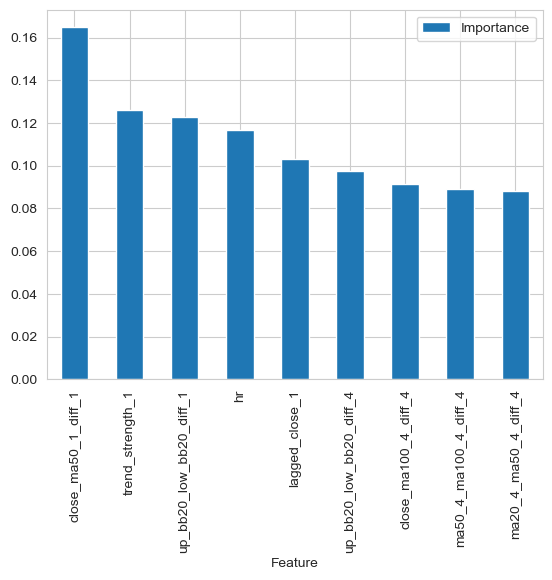

In [227]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

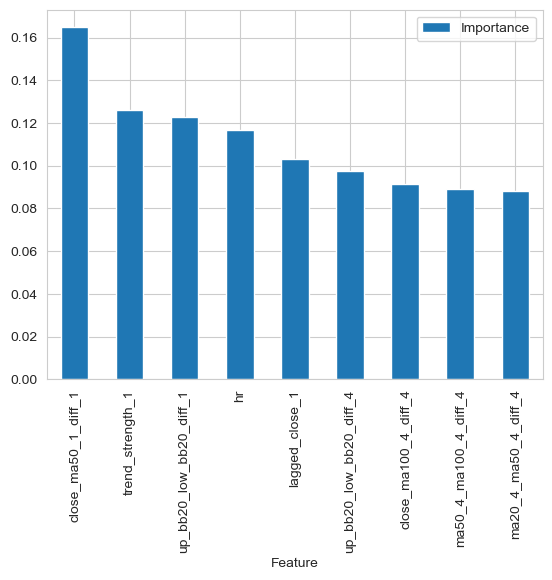

In [228]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job! Clear cell's outputs, push to the repo using git commands and move on to the next notebook

---

In [229]:
print(X_test[:1])

      close_ma50_1_diff_1  trend_strength_1  up_bb20_low_bb20_diff_1  hr  \
3246             -1.16642                 0                 2.117643   3   

      lagged_close_1  up_bb20_low_bb20_diff_4  close_ma100_4_diff_4  \
3246         138.493                  5.48526              -4.73203   

      ma50_4_ma100_4_diff_4  ma20_4_ma50_4_diff_4  
3246               -0.26353              -2.18465  


## Load the model

In [ ]:
## Load the model
from src.machine_learning.predictive_analysis_ui import (
    predict_binary_output, predict_profits)

version = 'v2'
profit_pip = load_pkl_file(
        f"outputs/predict_profits/{version}/clf_pipeline.pkl")
profit_labels_map = load_pkl_file(
        f"outputs/predict_profits/{version}/label_map.pkl")
profit_features = (pd.read_csv(f"outputs/predict_profits/{version}/X_train.csv")
                       .columns
                       .to_list()
                       )

In [254]:
print(X_test[:1])

t = X_test[:1]
t.iloc[0, t.columns.get_loc('close_ma50_1_diff_1')] = -0.05
t.iloc[0, t.columns.get_loc('trend_strength_1')] = 0
t.iloc[0, t.columns.get_loc('up_bb20_low_bb20_diff_1')] = 2.117643139
t.iloc[0, t.columns.get_loc('hr')] = 0
t.iloc[0, t.columns.get_loc('lagged_close_1')] = 147.83
t.iloc[0, t.columns.get_loc('up_bb20_low_bb20_diff_4')] = 2.
t.iloc[0, t.columns.get_loc('close_ma100_4_diff_4')] = -1.5
t.iloc[0, t.columns.get_loc('ma50_4_ma100_4_diff_4')] = -0.5
t.iloc[0, t.columns.get_loc('ma20_4_ma50_4_diff_4')] = -1
print(t.iloc[0])

predict_profits(t, profit_features,
                                profit_pip, profit_labels_map)

y_pred = pipeline_clf.predict(t)
y_prob = pipeline_clf.predict_proba(t)
pp = y_prob[0,y_pred][0]*100

print(y_pred)
print(pp)

print("probability",y_prob)



      close_ma50_1_diff_1  trend_strength_1  up_bb20_low_bb20_diff_1  hr  \
3246                -0.05                 0                 2.117643   0   

      lagged_close_1  up_bb20_low_bb20_diff_4  close_ma100_4_diff_4  \
3246           145.0                      2.0                  -1.5   

      ma50_4_ma100_4_diff_4  ma20_4_ma50_4_diff_4  
3246                   -0.5                  -1.0  
close_ma50_1_diff_1         -0.050000
trend_strength_1             0.000000
up_bb20_low_bb20_diff_1      2.117643
hr                           0.000000
lagged_close_1             147.830000
up_bb20_low_bb20_diff_4      2.000000
close_ma100_4_diff_4        -1.500000
ma50_4_ma100_4_diff_4       -0.500000
ma20_4_ma50_4_diff_4        -1.000000
Name: 3246, dtype: float64
[5]
19.254014247582994
probability [[0.15940421 0.18706248 0.14561114 0.16820602 0.14717601 0.19254014]]
